In [20]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from captum.attr import LayerGradCam
import torchvision
import pandas as pd
import os
import multiprocessing as mp
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
import pydicom
from PIL import Image

In [18]:
def load_dicom(fname):
    
#     fname = fname + '.dcm'
    
    dicom = pydicom.read_file(fname)
    data = dicom.pixel_array
    
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    
    img_array = (data * 255).astype(np.uint8)
    
    return img_array

In [4]:
def load_checkpoint(filepath):
    if torch.cuda.is_available():
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath,map_location=torch.device('cpu'))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [5]:
class customNet(nn.Module):
    def __init__(self, output_nodes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        feature_size = 256
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=feature_size),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=feature_size, out_features=output_nodes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [8]:
_MODEL_PATH = './model'

In [12]:
fname = './data'

In [9]:
glob(os.path.join(_MODEL_PATH,'*'))

['./model/checkpoint_4799_anno_instance_baseline.pth']

In [14]:
glob(os.path.join(fname,'*.dcm'))

['./data/pos_instance.dcm']

In [10]:
model = load_checkpoint(glob(os.path.join(_MODEL_PATH,'*'))[0])

In [29]:
conv_layer = model.base_model.layer4[-1].conv3

In [24]:
img = load_dicom(glob(os.path.join(fname,'*.dcm'))[0])
# img = Image.fromarray(np.uint8(img_array)).convert('RGB')
# plt.imshow(img)

(-0.5, 255.5, 255.5, -0.5)

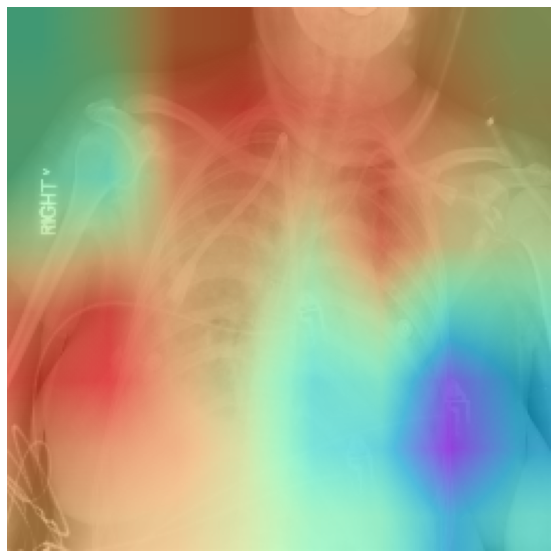

In [36]:
fig = plt.figure(figsize=(10, 10))

# img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
x = np.transpose(img, (2,0,1))
x = x/255
imagenet_mean = np.asarray([0.485, 0.456, 0.406]).reshape([3, 1, 1])
imagenet_std = np.asarray([0.229, 0.224, 0.225]).reshape([3, 1, 1])
x = (x-imagenet_mean)/imagenet_std
x = torch.FloatTensor(x)
x = torch.unsqueeze(x,0)

x.requires_grad = True

layer_gc = LayerGradCam(model, conv_layer)

grad_cam = layer_gc.attribute(x)[0][0].detach().cpu().numpy()

grad_cam = cv2.resize(grad_cam, (256,256))

grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

grad_cam = (grad_cam*255).astype(int)
plt.imshow(img)
plt.imshow(grad_cam, cmap='rainbow', alpha=0.6)
plt.axis('off')